In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

/home/ali/anaconda3/envs/dl2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

In [3]:
# CNN architecture taken from https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()        
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output

In [4]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
        train_loss += loss
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    train_loss /= num_batches
    correct /= size
    return correct, train_loss.detach().item()


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss

In [5]:
model = CNN()
#model = FashionNetwork()
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
epochs = 10

# Task 1 - Optimizers

### Optimizer: SGD
 Epoch 01: 	Train Accuracy: 36.98%, Train Loss: 2.071,	Test Accuracy: 57.24%, Test Loss: 1.525
 Epoch 02: 	Train Accuracy: 66.60%, Train Loss: 1.042,	Test Accuracy: 70.52%, Test Loss: 0.8425
 Epoch 03: 	Train Accuracy: 72.69%, Train Loss: 0.7771,	Test Accuracy: 73.71%, Test Loss: 0.7462
 Epoch 04: 	Train Accuracy: 74.86%, Train Loss: 0.7106,	Test Accuracy: 74.72%, Test Loss: 0.7039
 Epoch 05: 	Train Accuracy: 75.84%, Train Loss: 0.6753,	Test Accuracy: 75.53%, Test Loss: 0.6787
 Epoch 06: 	Train Accuracy: 76.65%, Train Loss: 0.6514,	Test Accuracy: 76.00%, Test Loss: 0.661
 Epoch 07: 	Train Accuracy: 77.29%, Train Loss: 0.633,	Test Accuracy: 76.39%, Test Loss: 0.6471
 Epoch 08: 	Train Accuracy: 77.87%, Train Loss: 0.6177,	Test Accuracy: 76.72%, Test Loss: 0.6353
 Epoch 09: 	Train Accuracy: 78.41%, Train Loss: 0.6044,	Test Accuracy: 76.86%, Test Loss: 0.6247
 Epoch 10: 	Train Accuracy: 78.85%, Train Loss: 0.5922,	Test Accuracy: 77.15%, Test Loss: 0.6146
### Optimizer: A

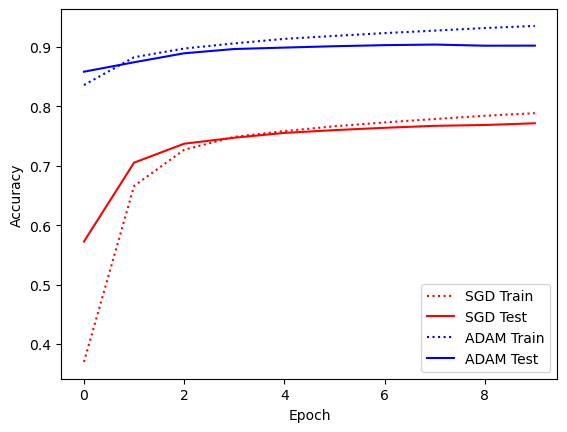

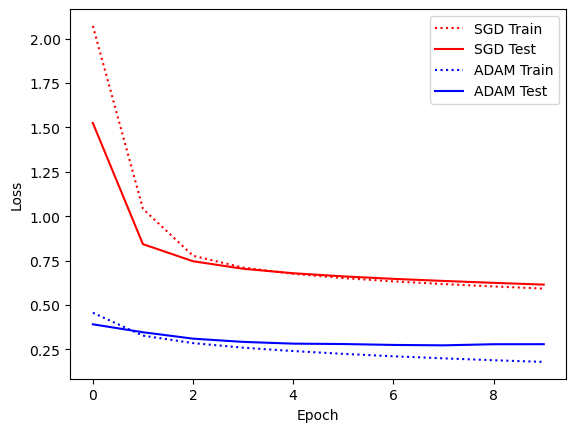

In [6]:
batch_size = 64
optimizers = [('SGD', torch.optim.SGD), ('ADAM', torch.optim.Adam)]
loss = {}
acc = {}

for (optimizer_name, optimizer) in optimizers:
    print('### Optimizer:', optimizer_name)
    optimizer = optimizer(model.parameters(), lr=learning_rate)

    acc[f'{optimizer_name} Train'] = []
    acc[f'{optimizer_name} Test']  = []
    loss[f'{optimizer_name} Train'] = []
    loss[f'{optimizer_name} Test']  = []
    
    for epoch in range(epochs):
        print(f' Epoch {epoch+1:02}: ', end='\t')
        train_acc, train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
        print(f'Train Accuracy: {train_acc:.2%},', f'Train Loss: {train_loss:.4}', end=',\t')

        test_acc, test_loss = test_loop(test_dataloader, model, loss_fn)
        print(f'Test Accuracy: {test_acc:.2%},', f'Test Loss: {test_loss:.4}')

        loss[f'{optimizer_name} Train'].append(train_loss)
        loss[f'{optimizer_name} Test'].append(test_loss)
        acc[f'{optimizer_name} Train'].append(train_acc)
        acc[f'{optimizer_name} Test'].append(test_acc)
        
linestyle = {'SGD Train': ':r', 'ADAM Train': ':b', 'SGD Test': 'r', 'ADAM Test': 'b'}

pd.DataFrame(acc).plot(style=linestyle)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

pd.DataFrame(loss).plot(style=linestyle)
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

# Task 2 - Batch sizes

### Batch Size: 8
 Epoch 01: 	Train Accuracy: 85.63%, Train Loss: 0.397,	Test Accuracy: 88.45%, Test Loss: 0.3175
 Epoch 02: 	Train Accuracy: 89.77%, Train Loss: 0.2799,	Test Accuracy: 89.65%, Test Loss: 0.2852
 Epoch 03: 	Train Accuracy: 91.09%, Train Loss: 0.2429,	Test Accuracy: 90.16%, Test Loss: 0.2776
 Epoch 04: 	Train Accuracy: 92.05%, Train Loss: 0.2183,	Test Accuracy: 90.41%, Test Loss: 0.275
 Epoch 05: 	Train Accuracy: 92.82%, Train Loss: 0.1987,	Test Accuracy: 90.10%, Test Loss: 0.2929
 Epoch 06: 	Train Accuracy: 93.28%, Train Loss: 0.1848,	Test Accuracy: 90.43%, Test Loss: 0.2965
 Epoch 07: 	Train Accuracy: 93.64%, Train Loss: 0.1736,	Test Accuracy: 90.66%, Test Loss: 0.3093
 Epoch 08: 	Train Accuracy: 94.19%, Train Loss: 0.1614,	Test Accuracy: 90.54%, Test Loss: 0.3254
 Epoch 09: 	Train Accuracy: 94.48%, Train Loss: 0.1517,	Test Accuracy: 90.05%, Test Loss: 0.3475
 Epoch 10: 	Train Accuracy: 94.77%, Train Loss: 0.1448,	Test Accuracy: 89.92%, Test Loss: 0.357
### Batch Size:

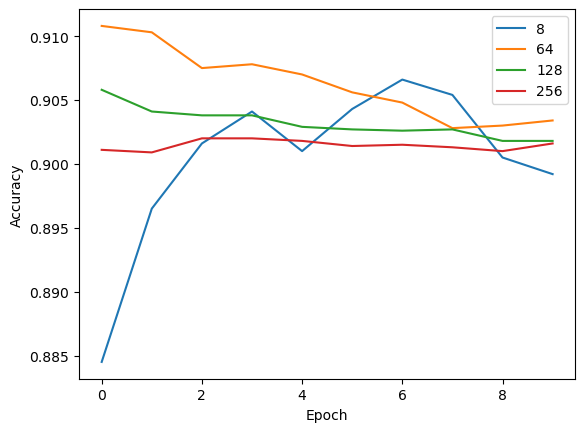

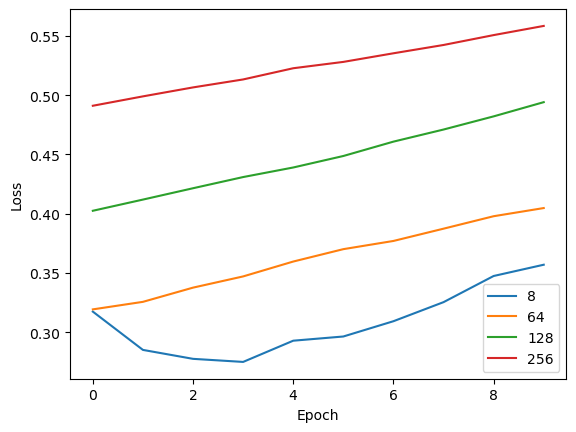

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
acc = {}
loss = {}

batch_sizes = [8, 64, 128, 256]

for batch_size in batch_sizes:
    print('### Batch Size:', batch_size)
    train_data_loader = DataLoader(training_data, batch_size=batch_size)
    test_data_loader = DataLoader(test_data, batch_size=batch_size)

    acc[batch_size]  = []
    loss[batch_size]  = []
    
    for epoch in range(epochs):
        print(f' Epoch {epoch+1:02}: ', end='\t')
        train_acc, train_loss = train_loop(train_data_loader, model, loss_fn, optimizer)
        print(f'Train Accuracy: {train_acc:.2%},', f'Train Loss: {train_loss:.4}', end=',\t')

        test_acc, test_loss = test_loop(test_data_loader, model, loss_fn)
        print(f'Test Accuracy: {test_acc:.2%},', f'Test Loss: {test_loss:.4}')

        acc[batch_size].append(test_acc)
        loss[batch_size].append(test_loss)
        

pd.DataFrame(acc).plot()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

pd.DataFrame(loss).plot()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()